In [1]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using HCubature

include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

Did not find xfac. QTT functions will not be available.PyError (PyImport_ImportModule

The Python package xfacpy could not be imported by pyimport. Usually this means
that you did not install xfacpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/Ritter.Marc/.pyenv/versions/3.8.15/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the xfacpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the P

3-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -0.0 - 1.0im; 0.0 + 1.0im 0.0 + 0.0im]
 [1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

# Hamiltonian

This Hamiltonian is the simplest one that creates a nontrivial topology in the band structure. It is diagonal in $\mathbf{k}$:
$$ H = \sum_{\mathbf{k}} \mathbf{c}_{\mathbf{k}}^\dagger h_{\mathbf{k}} \mathbf{c}_{\mathbf{k}} $$
with a spinor $\mathbf{c}(\mathbf{k})$ corresponding to two sublattices of a square lattice. The "$\mathbf{k}$-local" hamiltonian is
$$ h(\mathbf{k}) = \sigma_x \sin(k_x) + \sigma_y \sin(k_y) + \sigma_z (m + \cos(k_x) + \cos(k_y)) $$
where $m$ is a parameter that can tune through different phases.

- For $m < -2$, we have trivial topology $\mathcal{C} = 0$
- For $-2 < m < 0$, $\mathcal{C} = -1$
- For $0 < m < +2$, $\mathcal{C} = +1$
- For $+2 < m$, $\mathcal{C} = 0$ again.

At $m \in {-2, 0, +2}$, a dirac cone closes and the chern number changes. Therefore, the gap scales with the distance $\delta m$ from these points, and we can tune the difficulty of the problem (and the necessary lattice size!) using $\delta m$.

In the following, I use $m = -1.98$ as an example, i.e. $\delta m = 0.02$.

Gap ≈ 0.20000000000000018


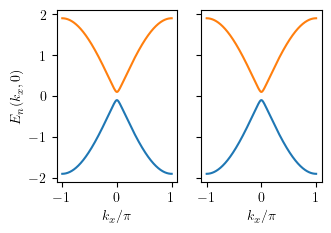

In [15]:
function H(k::Vector{Float64}, m::Float64, t2::Float64)
    return (
        pauli[1] * sin(k[1]) + pauli[2] * sin(k[2]) +
        pauli[3] * (m + cos(k[1]) + cos(k[2]) + t2 * cos(2 * k[1]) * cos(4 * k[2]))
    )
end

t2 = 0.0
m = -2.0 - t2 + 0.1

nquantics = 10
ndiscretization = 2^nquantics
kvals = range(-pi, pi; length=ndiscretization+1)[2:end]

bands = [eigvals(H([kx, ky], m, t2)) for kx in kvals, ky in kvals]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72), sharey=true)
axs[1].plot(kvals / pi, bands[:, div(ndiscretization, 2)]);
axs[2].plot(kvals / pi, bands[div(ndiscretization, 2), :]);

# axs.set_title("Band structure")
axs[1].set_xlabel(L"$k_x / \pi$")
axs[2].set_xlabel(L"$k_x / \pi$")
axs[1].set_ylabel(L"$E_n(k_x, 0)$")

gap = minimum(b[2] for b in bands) - maximum(b[1] for b in bands)
println("Gap ≈ $gap")

Note how the dirac cone almost closes, but not quite. The gap is $\approx 2\delta m$.

For completeness, here's the full (2d) band structure:

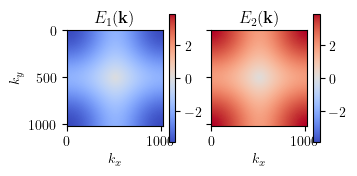

In [16]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))

vmax = maximum([maximum(abs.(b)) for b in bands])

axs[1].imshow([b[1] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax) |> colorbar
axs[2].imshow([b[2] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax) |> colorbar

axs[1].set_title(L"$E_1(\mathbf{k})$")
axs[2].set_title(L"$E_2(\mathbf{k})$")

axs[1].set_ylabel(L"$k_y$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$");

# Berry curvature

We can get an approximate Berry curvature per plaquette using the method discussed in the paper draft.

For almost touching bands, enough resolution is required to decide whether the bands are actually touching or separated by a small gap. The Berry curvature becomes sharper as the gap closes. Thus, we can use $\delta m$ to tune the difficulty of our problem. The minimum mesh size should scale $\sim 1/\delta m^d$. If it is smaller, resolution is insufficient.

Chern number from direct sum: -1.000000000000026


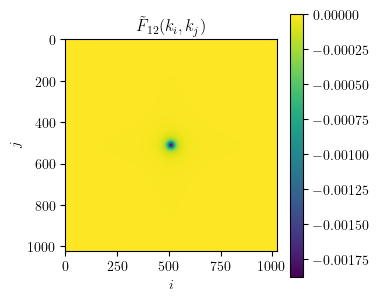

In [17]:
fig, axs = subplots(figsize=(246/72, 246/72))
time_direct = @elapsed A = chern.berrycurvature_dets([H([kx, ky], m, t2) for kx in kvals, ky in kvals], 1)
axs.imshow(A) |> colorbar

axs.set_title(L"$\tilde F_{12}(k_i, k_j)$")
axs.set_xlabel(L"$i$")
axs.set_ylabel(L"$j$")

println("Chern number from direct sum: $(sum(A) / 2pi)")

In logscale to reveal the structure in the background:

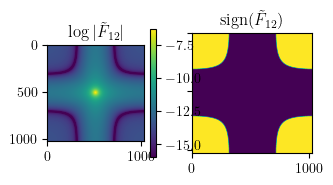

PyObject Text(0.5, 1.0, '$\\mathrm{sign}(\\tilde{F}_{12})$')

In [18]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow(log.(abs.(A)), vmin=-16) |> colorbar
axs[2].imshow(sign.(A))

axs[1].set_title(L"$\log|\tilde{F}_{12}|$")
axs[2].set_title(L"$\mathrm{sign}(\tilde{F}_{12})$")

# Quantics TCI

At each step, I evaluate the sum of the current approximation to see how large of a bond dimension we would need to identify the Chern number; hence the lengthy code.

In [19]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::TCI.MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::TCI.SweepStrategies.SweepStrategy=TCI.SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    errornormalization::Union{Nothing,Float64}=nothing,
    verbosity::Int=0
) where {ValueType}
    tci = TCI.TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    cherns = Float64[]
    ranks = Int[]
    N::Float64 = isnothing(errornormalization) ? abs(f(firstpivot)) : abs(errornormalization)

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == TCI.SweepStrategies.forward ||
            (sweepstrategy != TCI.SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            TCI.addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            TCI.addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        push!(errors, TCI.lastsweeppivoterror(tci) / N)
        push!(ranks, maximum(rank(tci)))
        push!(cherns, sumqtt(TCI.tensortrain(tci))  / 2pi)

        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    return tci, ranks, errors, cherns
end

f(q) = chern.berrycurvature_quantics_dets(
    kindex -> H([kvals[kindex[1]], kvals[kindex[2]]], m, t2),
    1, q, nquantics)

@show firstpivot = TCI.optfirstpivot(f, fill(4, nquantics), rand([1, 2, 3, 4], nquantics))
time_tci = @elapsed tci, ranks, errors, cherns = crossinterpolate_chern(
    Float64,
    f,
    fill(4, nquantics),
    firstpivot,
    tolerance=1e-4,
    maxiter=200
)

firstpivot = TCI.optfirstpivot(f, fill(4, nquantics), rand([1, 2, 3, 4], nquantics)) = [3, 2, 2, 2, 2, 2, 2, 2, 2, 2]


1.462369791

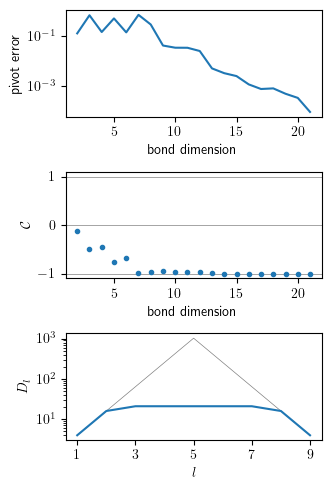

In [20]:
fig, axs = subplots(nrows=3, figsize=[246/72, 500/100])

axs[1].semilogy(ranks, errors)
axs[1].set_xlabel("bond dimension")
axs[1].set_ylabel("pivot error")

for c in [-1, 0, 1]
    axs[2].axhline(c, color="gray", linewidth=0.5)
end
axs[2].plot(ranks, cherns, ".")
axs[2].set_xlabel("bond dimension")
axs[2].set_ylabel(L"$\mathcal{C}$")

axs[3].semilogy(1:nquantics-1, maxlinkdim(nquantics, 4)[2], color="gray", linewidth=0.5)
axs[3].semilogy(1:nquantics-1, TCI.linkdims(tci))
axs[3].set_ylabel(L"$D_l$")
axs[3].set_xlabel(L"$l$")
axs[3].set_xticks(1:2:nquantics-1)

tight_layout()

After bond dimension $\approx 10$, exponential decay sets in. At $\approx 15$, we can be fairly confident that $\mathcal{C} = -1$.

In [21]:
println("For ($ndiscretization)^2 grid points, direct evalution took $time_direct seconds; TCI constructed in $time_tci seconds.")

For (1024)^2 grid points, direct evalution took 3.55106625 seconds; TCI constructed in 1.462369791 seconds.


Of course, this lattice is not so large that direct evaluation is inefficient, but TCI has an advantage anyway. Furthermore, a significant part of the time estimate for TCI is the repeated evaluation of the chern number, which is not necessary to construct the TCI itself.

# Explicit checks

Explicitly check the approximation. Ironically, evaluating the QTT for this many index values takes much longer than obtaining the QTT in the first place.

In [22]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

tt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(tt, merge_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in eachindex(kvals), kyi in eachindex(kvals)
];

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -12) = -12.0
vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = 0.0


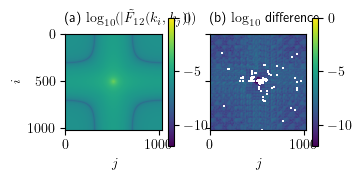

In [23]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -12)
@show vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=2, figsize=(246/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
# axs[2].imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata .- A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar

labels = [
    L"(a) $\log_{10}(|\tilde{F}_{12}(k_i, k_j)|)$",
    #L"(b) $\log_{10}$ QTT",
    L"(b) $\log_{10}$ difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

$\tilde F_{12}$ is well approximated; I cut the color scale at $10^{-12}$ to make structures more visible. The white spots are points with exactly $0$ difference, where the $\log_{10}$ is ill-defined.

Explicit evaluation of the QTT sum gives the chern number up to the accuracy that we specified in the TCI; here, it's $10^{-4}$.

In [24]:
sumqtt(tt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(-0.9999408869262663, -0.9999408869262663, -1.000000000000026)

# Different parameters

For different choices of $m$, this model has a Berry curvature with extended structure as well.

m = -2.1 Chern number from direct sum: -6.979550550989384e-15
m = -1.9 Chern number from direct sum: -0.9999999999999999
m = -1.0 Chern number from direct sum: -0.9999999999999954
m = -0.1 Chern number from direct sum: -0.9999999999999856
m = 0.1 Chern number from direct sum: 0.9999999999999887
m = 1.0 Chern number from direct sum: 0.9999999999999876
m = 1.9 Chern number from direct sum: 1.0000000000000056
m = 2.1 Chern number from direct sum: 1.79966385726144e-14


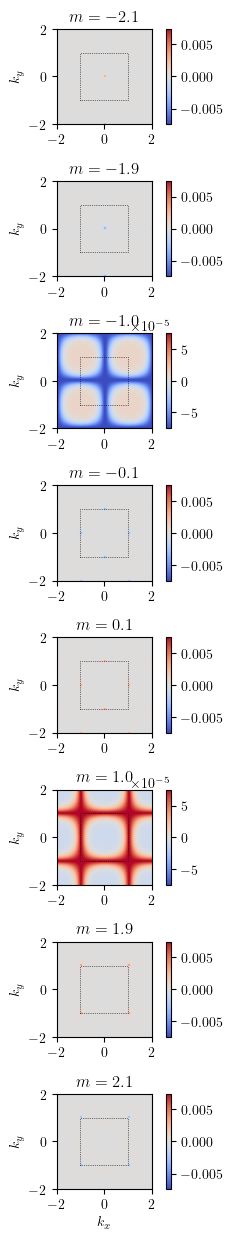

In [25]:
mvals = [-2.1, -1.9, -1, -0.1, 0.1, 1, 1.9, 2.1]
berrycurvatures = [
    chern.berrycurvature_dets([H(2 .* [kx, ky], mval, t2) for kx in kvals, ky in kvals], 1)
    for mval in mvals
]

extent = [-2, 2, -2, 2]

fig, axs = subplots(nrows=length(mvals), figsize=(246/72, 900/72))
for (ax, m, F) in zip(axs, mvals, berrycurvatures)
    vmax = maximum(abs.(F))
    ax.imshow(F, cmap="coolwarm", extent=extent, vmin=-vmax, vmax=vmax) |> colorbar
    ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], color="k", linestyle="dotted", linewidth=0.5)

    ax.set_title("\$m = $m\$")
    ax.set_ylabel(L"$k_y$")
    
    println("m = $m Chern number from direct sum: $(sum(F) / 8pi)")
end

axs[end].set_xlabel(L"$k_x$")
tight_layout()

(Dotted line is the Brillouin zone boundary)

# Deriv method

m = -2.1 Chern number from direct sum: 7.089986477429089e-16
m = -1.9 Chern number from direct sum: 1.0132118364233766
m = -1.0 Chern number from direct sum: 1.0132118364233775
m = -0.1 Chern number from direct sum: 1.0132118364233766
m = 0.1 Chern number from direct sum: -1.0132118364233773
m = 1.0 Chern number from direct sum: -1.0132118364233778
m = 1.9 Chern number from direct sum: -1.0132118364233778
m = 2.1 Chern number from direct sum: 2.208718528794109e-17


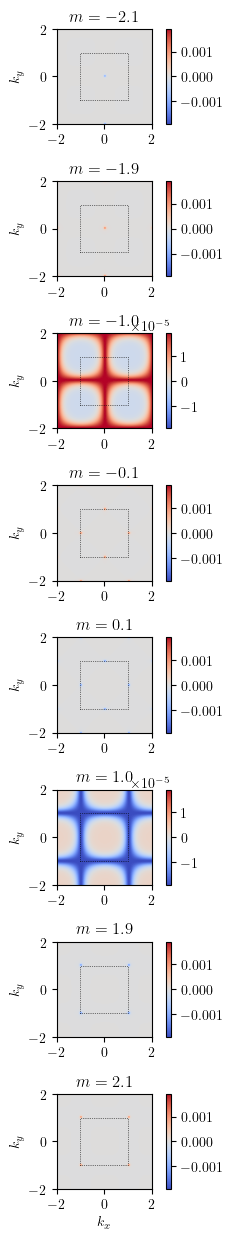

In [37]:
function Hd(k::Vector{Float64}, m::Float64, t2::Float64, dir::Int64)
    return (
        pauli[dir] * cos(k[dir]) +
        pauli[3] * (
            -sin(k[dir]) +
            t2 * (
                dir == 1
                ? -sin(2 * k[1]) * 2 * cos(4 * k[2])
                : -cos(2 * k[1]) * sin(4 * k[2]) * 4
            )
        )
    )
end

berrycurvatures_deriv = [
    [
        40 / (length(kvals)^2) *
        chern.berrycurvature_derivatives(
            H(2 .* [kx, ky], mval, t2),
            Hd(2 .* [kx, ky], mval, t2, 1),
            Hd(2 .* [kx, ky], mval, t2, 2),
            1) 
        for kx in kvals, ky in kvals
    ] for mval in mvals
]

extent = [-2, 2, -2, 2]

fig, axs = subplots(nrows=length(mvals), figsize=(246/72, 900/72))
for (ax, m, F) in zip(axs, mvals, berrycurvatures_deriv)
    vmax = maximum(abs.(F))
    ax.imshow(F, cmap="coolwarm", extent=extent, vmin=-vmax, vmax=vmax) |> colorbar
    ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], color="k", linestyle="dotted", linewidth=0.5)

    ax.set_title("\$m = $m\$")
    ax.set_ylabel(L"$k_y$")
    
    println("m = $m Chern number from direct sum: $(sum(F) / 2pi)")
end

axs[end].set_xlabel(L"$k_x$")
tight_layout()

In [36]:
ints = [
    hcubature(
        k -> chern.berrycurvature_derivatives(
            H(Vector(k), mval, t2),
            Hd(Vector(k), mval, t2, 1),
            Hd(Vector(k), mval, t2, 2),
            1),
        [-2, -2], [2, 2],
        atol=1e-12
    )
    for mval in mvals
]

8-element Vector{Tuple{Float64, Float64}}:
 (-0.477573508260865, 9.469828434013756e-13)
 (5.7002949553301985, 1.0025731490476086e-12)
 (4.576790507709262, 9.999199566714027e-13)
 (2.037912106813294, 9.998416587059989e-13)
 (1.577634333118111, 9.998508827624456e-13)
 (0.5272664487912337, 9.996160997349059e-13)
 (0.24379025404952787, 9.996627802897293e-13)
 (0.21236565872388627, 9.992256889550696e-13)

In [35]:
ints ./ 2pi

LoadError: MethodError: no method matching /(::Tuple{Float64, Float64}, ::Float64)
[0mClosest candidates are:
[0m  /([91m::StridedArray{P}[39m, ::Real) where P<:Dates.Period at ~/src/julia/usr/share/julia/stdlib/v1.7/Dates/src/deprecated.jl:44
[0m  /([91m::Union{SparseArrays.SparseVector{Tv, Ti}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseVector{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}}, false}} where {Tv, Ti}[39m, ::Number) at ~/src/julia/usr/share/julia/stdlib/v1.7/SparseArrays/src/sparsevector.jl:1476
[0m  /([91m::Union{ColorTypes.LMS, ColorTypes.XYZ}[39m, ::Number) at ~/.julia/packages/Colors/yDxFN/src/algorithms.jl:9
[0m  ...

In [38]:
length(kvals)

1024